In [1]:
import torch
from src.data.data_utils import load_data, load_node_to_nearest_training
from src.utils import set_global_seeds, arg_parse, name_model, create_nested_defaultdict, \
    metric_mean, metric_std, default_cal_wdecay, save_prediction
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

/root/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import os.path as osp
import os
import time
from src.model.model import create_model
from pathlib import Path
from src.calibrator import rbs
from torch_geometric.utils import to_networkx
import scipy
import numpy as np
from torch import nn

### Dataset

In [5]:

# dataset_cora = Planetoid('./data/', 'Cora', transform=T.NormalizeFeatures())
# data_cora = dataset_cora[0].to(device)

In [5]:
import argparse
from src.calibloss import ECE

parser = argparse.ArgumentParser(description='train.py and calibration.py share the same arguments')
parser.add_argument('--seed', type=int, default=10, help='Random Seed')
parser.add_argument('--dataset', type=str, default='Cora', choices=['Cora','Citeseer', 'Pubmed', 
                    'Computers', 'Photo', 'CS', 'Physics', 'CoraFull'])
parser.add_argument('--split_type', type=str, default='5_3f_85', help='k-fold and test split')
parser.add_argument('--model', type=str, default='GCN', choices=['GCN', 'GAT'])
parser.add_argument('--verbose', action='store_true', default=False, help='Show training and validation loss')
parser.add_argument('--wdecay', type=float, default=5e-4, help='Weight decay for training phase')
parser.add_argument('--dropout_rate', type=float, default=0.5, help='Dropout rate. 1.0 denotes drop all the weights to zero')
parser.add_argument('--calibration', type=str, default='GATS',  help='Post-hoc calibrators')
parser.add_argument('--cal_wdecay', type=float, default=None, help='Weight decay for calibration phase')
parser.add_argument('--cal_dropout_rate', type=float, default=0.5, help='Dropout rate for calibrators (CaGCN)')
parser.add_argument('--folds', type=int, default=3, help='K folds cross-validation for calibration')
parser.add_argument('--ece-bins', type=int, default=15, help='number of bins for ece')
parser.add_argument('--ece-scheme', type=str, default='equal_width', choices=ECE.binning_schemes, help='binning scheme for ece')
parser.add_argument('--ece-norm', type=float, default=1.0, help='norm for ece')
parser.add_argument('--save_prediction', action='store_true', default=False)
parser.add_argument('--config', action='store_true', default=False)

gats_parser = parser.add_argument_group('optional GATS arguments')
gats_parser.add_argument('--heads', type=int, default=2, help='Number of heads for GATS. Hyperparameter set: {1,2,4,8,16}')
gats_parser.add_argument('--bias', type=float, default=1, help='Bias initialization for GATS')
args = parser.parse_args(['--dataset', 'Cora', '--calibration', 'TS'])

parser.add_argument("--alpha", type=float, default=0.98)
parser.add_argument("--lmbda", type=float, default=1.0)
parser.add_argument("--num_bins_rbs", type=int, default=2)
if args.config:
    config = read_config(args)
    for key, value in config.items():
        setattr(args, key, value)

args_dict = {}
for group in parser._action_groups:
    if group.title == 'optional GATS arguments':
        group_dict={a.dest:getattr(args,a.dest,None) for a in group._group_actions}
        args_dict['gats_args'] = argparse.Namespace(**group_dict)
    else:
        group_dict={a.dest:getattr(args,a.dest,None) for a in group._group_actions}
        args_dict.update(group_dict)
args = argparse.Namespace(**args_dict)

In [6]:
args

Namespace(alpha=None, cal_dropout_rate=0.5, cal_wdecay=None, calibration='TS', config=False, dataset='Cora', dropout_rate=0.5, ece_bins=15, ece_norm=1.0, ece_scheme='equal_width', folds=3, gats_args=Namespace(bias=1, heads=2), help=None, lmbda=None, model='GCN', num_bins_rbs=None, save_prediction=False, seed=10, split_type='5_3f_85', verbose=False, wdecay=0.0005)

In [7]:
fold = 1
split = 1
init =1
dataset = load_data(args.dataset, args.split_type, split, fold)
data = dataset.data.to(device)



In [8]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [9]:
data.x.shape

torch.Size([2708, 1433])

### model

In [10]:
model = create_model(dataset, args).to(device)
model_name = name_model(fold, args)
dir = Path(os.path.join('model_latest', args.dataset, args.split_type, 'split'+str(split), 'init'+ str(init)))
file_name = dir / (model_name + '.pt')
model.load_state_dict(torch.load(file_name))
torch.cuda.empty_cache()

In [11]:
model

GCN(
  (layer_list): ModuleDict(
    (conv1): GCNConv(1433, 64)
    (conv2): GCNConv(64, 7)
  )
)

### Modify Graph Struct

In [20]:
from torch_geometric.data import Data
import random

def modify_del_graph(data, delete_ratio=0.1):
    """
    Modify the graph by randomly deleting and adding edges based on node labels.

    Args:
        data (Data): The graph data object from torch_geometric.
        delete_ratio (float): The ratio of edges to delete based on label inconsistency.
    
    Returns:
        Data: The modified graph data with updated edges.
    """
    edge_index = data.edge_index
    num_edges = edge_index.size(1)
    dtype = edge_index.dtype
    # Convert edge_index to a list of edges
    edges = edge_index.t().tolist()
    
    # Get node labels
    labels = data.y.cpu().numpy()
    
    # Randomly delete edges with inconsistent labels
    edges_to_delete = []
    for u, v in edges:
        if labels[u] != labels[v] and random.random() < delete_ratio:
            edges_to_delete.append([u, v])
            edges_to_delete.append([v, u])
            edges.remove([u, v])
            edges.remove([v, u])
    
    # Convert edges back to edge_index format
    new_edge_index = torch.tensor(edges, dtype=dtype).t().contiguous()
    
    return new_edge_index



In [21]:
def modify_add_graph(data, add_ratio=0.1):
    """
    Modify the graph by randomly deleting and adding edges based on node labels.

    Args:
        data (Data): The graph data object from torch_geometric.
        add_ratio (float): The ratio of edges to add between nodes with the same label.
    
    Returns:
        Data: The modified graph data with updated edges.
    """
    edge_index = data.edge_index
    num_edges = edge_index.size(1)
    dtype = edge_index.dtype
    
    # Convert edge_index to a list of edges
    edges = edge_index.t().tolist()
    labels = data.y.cpu().numpy()

    # Randomly add edges between nodes with the same label
    num_nodes = data.num_nodes
    edges_to_add = []

    # num_edges_to_add = int(num_nodes * (num_nodes - 1) * add_ratio
    num_edges_to_add = int(num_edges * add_ratio / 2)
    
    for _ in range(num_edges_to_add):  # Each edge is counted twice
        u, v = random.sample(range(num_nodes), 2)
        if labels[u] == labels[v] and [u, v] not in edges and [v, u] not in edges:
            edges_to_add.append([u, v])
            edges_to_add.append([v, u])
            edges.append([u, v])
            edges.append([v, u])
    
    # Convert edges back to edge_index format
    new_edge_index = torch.tensor(edges, dtype=dtype).t().contiguous()
    
    return new_edge_index



In [24]:
delete_ratio=0.6
add_ratio=0.2
data = dataset.data.to(device)
delete_graph_data, new_del_index = modify_del_graph(data, delete_ratio)
add_graph_data = modify_add_graph(data, add_ratio)        

print(f'the original Cora dataset edges: {data.edge_index.size(1)}')      
print(f'the modify-delete Cora edges: {delete_graph_data.edge_index.size(1)} with ratio {delete_ratio}')      
print(f'the modeify-add Cora edges: {add_graph_data.edge_index.size(1)} with ratio {add_ratio}')    

the original Cora dataset edges: 10556


AttributeError: 'Tensor' object has no attribute 'edge_index'

In [55]:
def modify_add_cal_graph(data, add_ratio=0.1):
    """
    Modify the graph by randomly deleting and adding edges based on node labels.

    Args:
        data (Data): The graph data object from torch_geometric.
        add_ratio (float): The ratio of edges to add between nodes with the same label.
    
    Returns:
        Data: The modified graph data with updated edges.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    edge_index = data.edge_index
    num_edges = edge_index.size(1)
    dtype = edge_index.dtype
    
    # Convert edge_index to a list of edges
    edges = edge_index.t().tolist()
    labels = data.y.cpu().numpy()
    valid_node_indices = torch.nonzero(data.train_mask | data.val_mask).view(-1)

    # Randomly add edges between nodes with the same label
    num_nodes = data.num_nodes
    edges_to_add = []
    valid_edges_count = 0
    for u, v in edge_index.t().tolist():
        if u in valid_node_indices and v in valid_node_indices:
            valid_edges_count += 1
    print('the valid_edges_count is ', valid_edges_count)
    num_edges_to_add = int(valid_edges_count * add_ratio / 2)

    
    for _ in range(num_edges_to_add):  
        u, v = random.sample(valid_node_indices.tolist(), 2)
        if labels[u] == labels[v] and [u, v] not in edges and [v, u] not in edges:
            edges_to_add.append([u, v])
            edges_to_add.append([v, u])
            edges.append([u, v])
            edges.append([v, u])
    
    # Convert edges back to edge_index format
    new_edge_index = torch.tensor(edges, dtype=dtype).t().contiguous().to(device)
    
    return new_edge_index, valid_node_indices

In [67]:
def modify_del_cal_graph(data, delete_ratio=0.1):
    """
    Modify the graph by randomly deleting train-val edges based on node labels.

    Args:
        data (Data): The graph data object from torch_geometric.
        delete_ratio (float): The ratio of edges to delete based on label inconsistency.
    
    Returns:
        Data: The modified graph data with updated edges.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    edge_index = data.edge_index
    num_edges = edge_index.size(1)
    dtype = edge_index.dtype
    # Convert edge_index to a list of edges
    edges = edge_index.t().tolist()
    labels = data.y.cpu().numpy()

    valid_node_indices = torch.nonzero(data.train_mask | data.val_mask).view(-1)
    
    # Randomly delete edges with inconsistent labels
    edges_to_delete = []
    for u, v in edges:
        if (u in valid_node_indices) and (v in valid_node_indices):
            if labels[u] != labels[v] and random.random() < delete_ratio:
                edges_to_delete.append([u, v])
                edges_to_delete.append([v, u])
                edges.remove([u, v])
                edges.remove([v, u])
    
    # Convert edges back to edge_index format
    new_edge_index = torch.tensor(edges, dtype=dtype).t().contiguous().to(device)
    
    return new_edge_index

In [78]:
delete_ratio=1.2
add_ratio=0.2
data2 = dataset2.data.to(device)
new_del_index_del = modify_del_cal_graph(data2, delete_ratio)
new_add_index_add, valid_node_indices = modify_add_cal_graph(data2, add_ratio)

the valid_edges_count is  266


In [79]:
print(data2.edge_index.shape)
new_del_index_del.shape

torch.Size([2, 10556])


torch.Size([2, 10504])

tensor([   0,    4,   15,   20,   29,   31,   35,   39,   42,   43,   49,   72,
          85,   88,   99,  101,  102,  109,  128,  138,  140,  141,  142,  154,
         156,  160,  169,  170,  172,  174,  178,  181,  189,  192,  194,  196,
         199,  201,  207,  211,  213,  218,  223,  224,  234,  245,  255,  260,
         278,  280,  284,  292,  293,  308,  310,  319,  331,  334,  342,  366,
         392,  396,  398,  400,  406,  407,  422,  429,  433,  448,  449,  452,
         456,  460,  462,  466,  470,  477,  480,  494,  498,  501,  504,  510,
         512,  514,  516,  532,  551,  557,  565,  569,  574,  576,  589,  594,
         601,  611,  612,  619,  625,  626,  628,  630,  633,  648,  659,  679,
         681,  702,  716,  722,  723,  730,  734,  738,  739,  745,  749,  753,
         754,  755,  756,  767,  770,  773,  775,  788,  791,  794,  796,  798,
         799,  811,  817,  832,  846,  857,  867,  897,  902,  914,  932,  938,
         946,  951,  952,  954,  976,  9

In [82]:
valid_edges_count = 0
for u, v in data2.edge_index.t().tolist():
    if u in valid_node_indices and v in valid_node_indices:
        # print(u, v)
        valid_edges_count += 1
print(valid_edges_count)
print(int(valid_edges_count * (valid_edges_count-1) / 2))

266
35245


In [64]:
data2.edge_index.shape

torch.Size([2, 10556])

In [89]:
data2.edge_index = new_del_index

In [90]:
data2

Data(x=[2708, 1433], edge_index=[2, 9096], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [82]:
print(data2)
delete_graph_data


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Data(x=[2708, 1433], edge_index=[2, 9092], y=[2708])

## Visualize

### calibration-accuracy

In [12]:
from src.utils import create_nested_defaultdict
from src.calibration_uncal import eval as eval_test

eval_type_list = ['Nodewise']
reliabilities_uncal = []
uncal_test_total = create_nested_defaultdict(eval_type_list)
with torch.no_grad():
    model.eval()
    logits = model(data.x, data.edge_index)
for eval_type in eval_type_list:
    eval_result, reliability = eval_test(data, logits, 'Test')
    reliabilities_uncal.append(reliability)


In [13]:
reliabilities_uncal[0]

Reliability(conf=tensor([0.0000e+00, 0.0000e+00, 1.8648e-01, 1.2018e+01, 2.5231e+01, 4.7376e+01,
        5.9946e+01, 6.7207e+01, 8.6949e+01, 1.0003e+02, 1.0259e+02, 1.3893e+02,
        1.8952e+02, 2.2885e+02, 2.9484e+02], device='cuda:0'), acc=tensor([  0.,   0.,   0.,  19.,  39.,  72.,  86.,  97., 117., 142., 138., 170.,
        214., 245., 298.], device='cuda:0'), count=tensor([  0,   0,   1,  50,  83, 128, 137, 134, 153, 158, 146, 181, 227, 254,
        305], device='cuda:0'))

In [14]:
reliabilities_uncal[0]

Reliability(conf=tensor([0.0000e+00, 0.0000e+00, 1.8648e-01, 1.2018e+01, 2.5231e+01, 4.7376e+01,
        5.9946e+01, 6.7207e+01, 8.6949e+01, 1.0003e+02, 1.0259e+02, 1.3893e+02,
        1.8952e+02, 2.2885e+02, 2.9484e+02], device='cuda:0'), acc=tensor([  0.,   0.,   0.,  19.,  39.,  72.,  86.,  97., 117., 142., 138., 170.,
        214., 245., 298.], device='cuda:0'), count=tensor([  0,   0,   1,  50,  83, 128, 137, 134, 153, 158, 146, 181, 227, 254,
        305], device='cuda:0'))

In [21]:
print(data.test_mask.sum() == reliabilities_uncal[0].count.sum())
print(reliabilities_uncal[0].count)

confs = [(r[0] / (r[2] + torch.finfo().tiny)).cpu().numpy()
             for r in reliabilities_uncal]
accs = [(r[1] / (r[2] + torch.finfo().tiny)).cpu().numpy()
            for r in reliabilities_uncal]

tensor(True, device='cuda:0')
tensor([  0,   0,   1,  50,  83, 128, 137, 134, 153, 158, 146, 181, 227, 254,
        305], device='cuda:0')


In [18]:
confs[0]

array([0.        , 0.        , 0.18648018, 0.24036114, 0.30399007,
       0.37012446, 0.43756554, 0.5015448 , 0.5682942 , 0.63310647,
       0.7026527 , 0.7675867 , 0.83490974, 0.9009998 , 0.9666956 ],
      dtype=float32)

In [20]:
accs[0]

array([0.        , 0.        , 0.        , 0.38      , 0.4698795 ,
       0.5625    , 0.6277372 , 0.7238806 , 0.7647059 , 0.89873415,
       0.94520545, 0.9392265 , 0.94273126, 0.96456695, 0.9770492 ],
      dtype=float32)

In [47]:
masks = [r[2].cpu().numpy() > 0 for r in reliabilities_uncal]

In [51]:
nonzero_counts = np.sum(np.asarray(masks, dtype=np.int64), axis=0)

In [52]:
nonzero_counts

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [53]:
masks

[array([False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True])]

In [55]:
masks=[np.array([False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True]), np.array([False, True,  True,  False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  False,  True])]

In [59]:
nonzero_counts = np.sum(np.asarray(masks, dtype=np.int64), axis=0)
nonzero_counts

array([0, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2])

In [60]:
nonzero_counts.sum()

25

### visualize-modify-edge

8 figure, 6 curves per fig

delete_ratio_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

add_iteration_list = [0, 20, 60, 100, 140, 180, 220, 260, 300, 500]

- delete-edge
    - valid
        - GCN(uncal/cal-TS; Cora/Citeseer/Pumbed)
        - GAT
    - all
- add-edge
    - valid
    - all

In [61]:
import matplotlib.pyplot as plt

def draw_del_ratio_ece(ratio_list, ece_uncal_cora, ece_cal_cora, 
                       ece_uncal_citeseer, ece_cal_citeseer, 
                       ece_uncal_pubmed, ece_cal_pubmed, title, save_path='line_graph.png'):
    """
    绘制折线图用于比较ratio-ECE，并保存图像。

    Args:
        ratio_list (list): 横轴 ratio 的变化
        ece_uncal_dataset (list): 未校准 ECE 值
        ece_cal_dataset (list): 校准 ECE 值
        save_path (str): 保存图像的路径和文件名
    """
    plt.figure(figsize=(12, 8))
    
    plt.plot(ratio_list, ece_uncal_cora, marker='o', label='Uncal-Cora', color='steelblue', linestyle='-')
    plt.plot(ratio_list, ece_cal_cora, marker='o', markerfacecolor='white', label='Cal-TS-Cora', color='steelblue', linestyle='--')
    
    plt.plot(ratio_list, ece_uncal_citeseer, marker='o', label='Uncal-Citeseer', color='goldenrod', linestyle='-')
    plt.plot(ratio_list, ece_cal_citeseer, marker='o', markerfacecolor='white', label='Cal-TS-Citeseer', color='goldenrod', linestyle='--')
    
    plt.plot(ratio_list, ece_uncal_pubmed, marker='o', label='Uncal-Pubmed', color='mediumpurple', linestyle='-')
    plt.plot(ratio_list, ece_cal_pubmed, marker='o', markerfacecolor='white', label='Cal-TS-Pubmed', color='mediumpurple', linestyle='--')
    
    plt.title(title)
    plt.xlabel('Ratio', fontsize=16)
    plt.ylabel('ECE', fontsize=16)
    
    plt.legend(loc='upper right')
    plt.grid(linestyle='-.')

    plt.savefig(save_path)
    print(f"Image save to {save_path}")
    plt.show()


In [62]:
def draw_add_ratio_ece(iteration_list, ece_uncal_cora, ece_cal_cora, 
                       ece_uncal_citeseer, ece_cal_citeseer, 
                       ece_uncal_pubmed, ece_cal_pubmed, title, save_path='line_graph.png'):
    """
    绘制折线图用于比较ratio-ECE，并保存图像。

    Args:
        ratio_list (list): 横轴 ratio 的变化
        ece_uncal_dataset (list): 未校准 ECE 值
        ece_cal_dataset (list): 校准 ECE 值
        save_path (str): 保存图像的路径和文件名
    """
    plt.figure(figsize=(12, 8))
    
    plt.plot(iteration_list, ece_uncal_cora, marker='o', label='Uncal-Cora', color='steelblue', linestyle='-')
    plt.plot(iteration_list, ece_cal_cora, marker='o',  markerfacecolor='white', label='Cal-TS-Cora', color='steelblue', linestyle='--')
    
    plt.plot(iteration_list, ece_uncal_citeseer, marker='o', label='Uncal-Citeseer', color='goldenrod', linestyle='-')
    plt.plot(iteration_list, ece_cal_citeseer, marker='o',  markerfacecolor='white', label='Cal-TS-Citeseer', color='goldenrod', linestyle='--')
    
    plt.plot(iteration_list, ece_uncal_pubmed, marker='o', label='Uncal-Pubmed', color='mediumpurple', linestyle='-')
    plt.plot(iteration_list, ece_cal_pubmed, marker='o',  markerfacecolor='white', label='Cal-TS-Pubmed', color='mediumpurple', linestyle='--')
    
    
    plt.title(title)
    plt.xlabel('Iteration', fontsize=16)
    plt.ylabel('ECE', fontsize=16)
    
    plt.legend(loc='upper right')
    plt.grid(linestyle='-.')

    plt.savefig(save_path)
    print(f"Image save to {save_path}")
    plt.show()


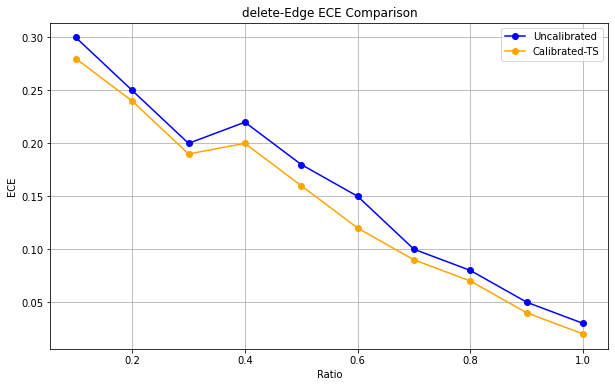

In [12]:
# 示例数据
ratio_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
edge_ece_uncal = [0.3, 0.25, 0.2, 0.22, 0.18, 0.15, 0.1, 0.08, 0.05, 0.03]
edge_ece_cal = [0.28, 0.24, 0.19, 0.2, 0.16, 0.12, 0.09, 0.07, 0.04, 0.02]

# 调用函数绘制图形并保存
draw_del_ratio_ece(ratio_list, edge_ece_uncal, edge_ece_cal, title='delete-Edge ECE Comparison', save_path='edge_ece_comparison.png')


#### delete-edge
ratio_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

Image save to figure/modify_edge/delete_valid_gcn.png


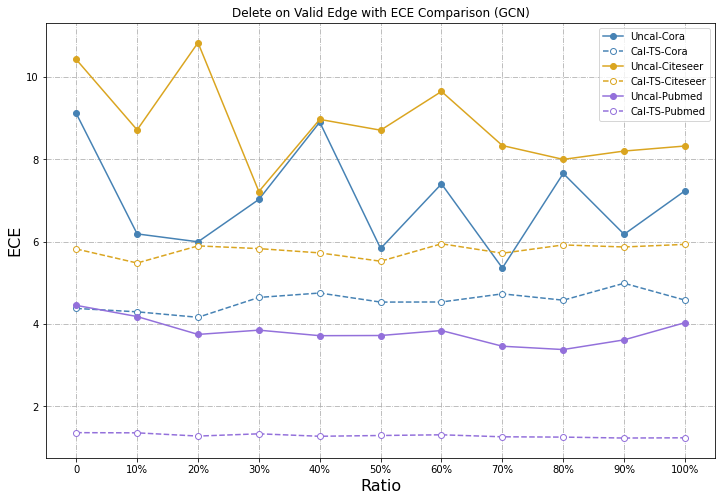

In [64]:
# 1. delete-valid GCN (uncal/cal-TS;  Cora/Citeseer/Pumbed)
# ratio_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
ratio_list = ['0', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
ece_uncal_cora = [9.117378439340326, 6.191313064967593, 5.999181781791978, 7.028954227765401, 8.906831406056881, 5.8371083293524055, 7.406674315118128, 5.3621326055791645, 7.6611498681207495, 6.181531896193823, 7.238919163743655]
ece_cal_cora = [4.379956206927696, 4.298005108204153, 4.164502024650574, 4.647375736385584, 4.75490844498078, 4.534213865796724, 4.536888375878334, 4.734625957078404, 4.580220300704241, 4.992079134616587, 4.582087736990717]
ece_uncal_citeseer = [10.42932795567645, 8.718901210361057, 10.83772223856714, 7.2209216343859834, 8.973895096116596, 8.711403049528599, 9.652829729020596, 8.33808494110902, 8.001635844508808, 8.204501287804709, 8.327007045348484]
ece_cal_citeseer = [5.825210031535891, 5.483675892982218, 5.900277073184649, 5.833766899175115, 5.729579759968652, 5.527138399581114, 5.951276773379909, 5.7214820550547705, 5.923177777893014, 5.873713849319352, 5.936649048493968]
ece_uncal_pubmed = [4.454725152916379, 4.182908828887674, 3.748705776201354, 3.8520873938169746, 3.7179409733249082, 3.7221769181390605, 3.843113873153925, 3.461769844094912, 3.3809823035779925, 3.6161822370356984, 4.034274961385462]
ece_cal_pubmed = [1.361630186955962, 1.3572334518863094, 1.2783755367207859, 1.3335550902411342, 1.2737339362502098, 1.292497105896473, 1.3096678898566299, 1.2609116008712185, 1.2533469384329188, 1.2309279499782455, 1.2366628222581413]
title1 = 'Delete on Valid Edge with ECE Comparison (GCN)'
spth1 = 'figure/modify_edge/delete_valid_gcn.png'
draw_del_ratio_ece(ratio_list, ece_uncal_cora, ece_cal_cora, 
                       ece_uncal_citeseer, ece_cal_citeseer, 
                       ece_uncal_pubmed, ece_cal_pubmed, title1, spth1)

Image save to figure/modify_edge/delete_valid_gat.png


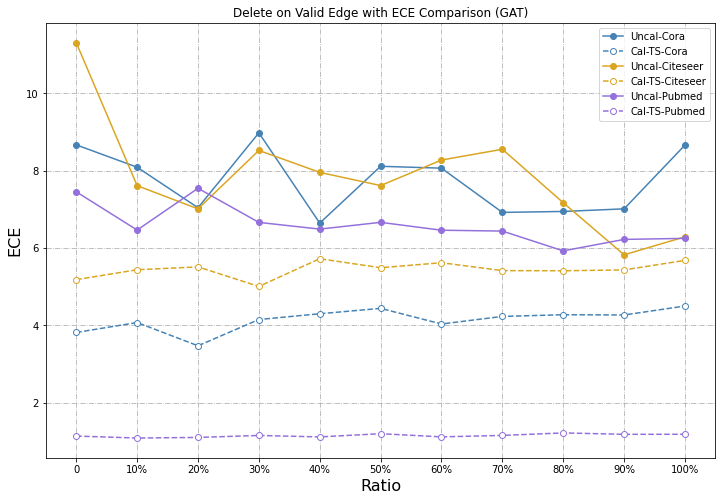

In [65]:
# 2. delete-valid GAT (uncal/cal-TS;  Cora/Citeseer/Pumbed)
ratio_list = ['0', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
ece_uncal_cora = [8.665825323098236, 8.087804085678524, 7.041784727738963, 8.976359303212828, 6.644681385821766, 8.112081109235685, 8.06357269692752, 6.920545248107778, 6.945129245933559, 7.012515877270037, 8.660991872764296]
ece_cal_cora = [3.8181453632811704, 4.075213832159838, 3.4742870471543736, 4.152578529384401, 4.301845654845238, 4.441100089914269, 4.037190839234325, 4.232791583571169, 4.276612349268463, 4.270245207266675, 4.5014254541860685]
ece_uncal_citeseer = [11.306050254238977, 7.611383973724312, 7.012257124814722, 8.522022370662954, 7.954555004835129, 7.614206646879514, 8.273854479193687, 8.55247624632385, 7.1706538502540855, 5.824889594482051, 6.290317223303848]
ece_cal_citeseer = [5.183413593719402, 5.439246342413955, 5.513005269070467, 5.007741217397981, 5.723964981734753, 5.490775220096111, 5.620548874139786, 5.416346175803079, 5.412831467886766, 5.434364473654164, 5.681181264420351]
ece_uncal_pubmed = [7.452928688791063, 6.4648434105846615, 7.543056023617585, 6.662401867409547, 6.488933331436581, 6.663829129603174, 6.459982651803228, 6.438493438892895, 5.926227031482591, 6.222943796051873, 6.249765265319082]
ece_cal_pubmed = [1.1414831711186302, 1.0904583950630493, 1.1060534355541072, 1.1565581998891301, 1.1196432169526815, 1.202492268445591, 1.1203650475686622, 1.1583858997457557, 1.2224158737808466, 1.1864308254896767, 1.1874523595906794]
title2 = 'Delete on Valid Edge with ECE Comparison (GAT)'
spth2 = 'figure/modify_edge/delete_valid_gat.png'
draw_del_ratio_ece(ratio_list, ece_uncal_cora, ece_cal_cora, 
                       ece_uncal_citeseer, ece_cal_citeseer, 
                       ece_uncal_pubmed, ece_cal_pubmed, title2, spth2)


Image save to figure/modify_edge/delete_all_gcn.png


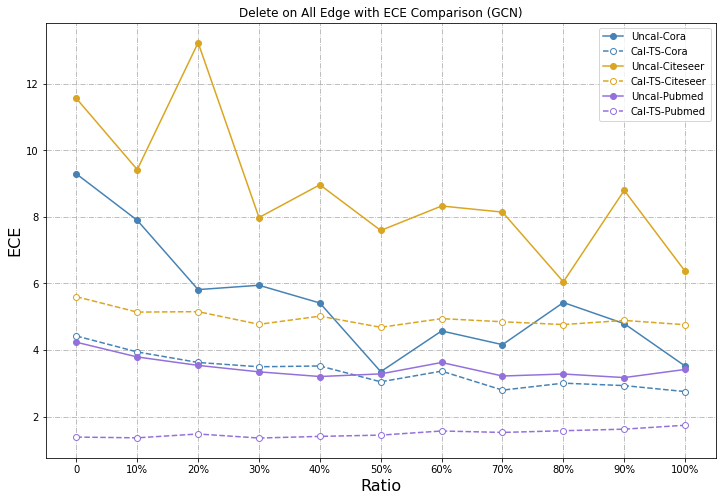

In [66]:
# 3. delete-all GCN (uncal/cal-TS;  Cora/Citeseer/Pumbed)
# ratio_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
ratio_list = ['0', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
ece_uncal_cora = [9.29586020194822, 7.900247298594978, 5.816504938734902, 5.946407943136163, 5.4136874464650955, 3.3483744081523685, 4.57327107174529, 4.161006460587183, 5.428122366882033, 4.792213626205921, 3.51679635544618]
ece_cal_cora = [4.421858582645655, 3.941672988649872, 3.624793214516507, 3.495616652071476, 3.519555108828677, 3.043772538916932, 3.3646531868726015, 2.7934174260331526, 3.002495877444744, 2.9298660138414965, 2.7493409553749695]
ece_uncal_citeseer = [11.564534943964746, 9.426192577100462, 13.241682863897747, 7.9832278192043304, 8.969069313671854, 7.594779692590237, 8.33058740115828, 8.146440279152658, 6.049719556338258, 8.801488516231377, 6.367111190532644]
ece_cal_citeseer = [5.603213152951665, 5.13988495286968, 5.1532997128864135, 4.771771985623571, 5.018234283973774, 4.6827319905989695, 4.943306795838806, 4.849375815441212, 4.765291946629683, 4.889815373139249, 4.760168720450666]
ece_uncal_pubmed = [4.2338404804468155, 3.790906351059675, 3.5370689816772938, 3.343121697091394, 3.202509321272373, 3.2818357149759927, 3.624818856931395, 3.217683763553699, 3.2779151159856053, 3.170598939889007, 3.4155939602189593]
ece_cal_pubmed = [1.3813578808266256, 1.3591133213291564, 1.4747260759274163, 1.3527833804902103, 1.4022247037953801, 1.4405807790656886, 1.564780974553691, 1.520995588766204, 1.5724431205954816, 1.6194940441184573, 1.737887707228462]
title3 = 'Delete on All Edge with ECE Comparison (GCN)'
spth3 = 'figure/modify_edge/delete_all_gcn.png'
draw_del_ratio_ece(ratio_list, ece_uncal_cora, ece_cal_cora, 
                       ece_uncal_citeseer, ece_cal_citeseer, 
                       ece_uncal_pubmed, ece_cal_pubmed, title3, spth3)


Image save to figure/modify_edge/delete_all_gat.png


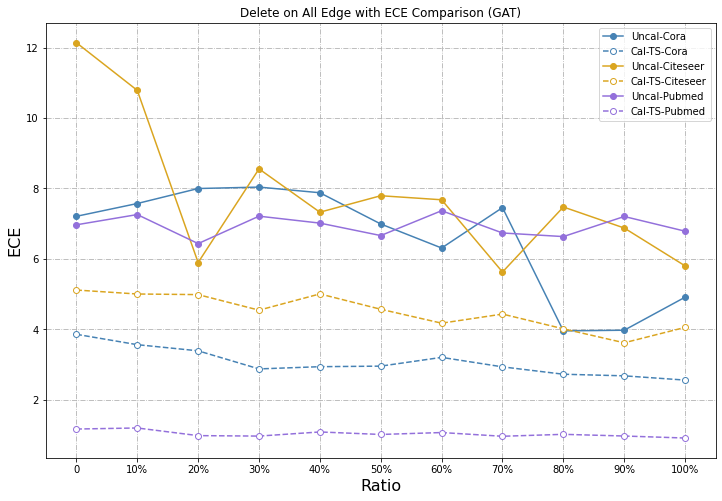

In [67]:
# 4. delete-all GAT (uncal/cal-TS;  Cora/Citeseer/Pumbed)
# ratio_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
ratio_list = ['0', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
ece_uncal_cora = [7.208659406751394, 7.572201877418491, 7.99779658102327, 8.038492355909613, 7.877939065090484, 6.9911097176373005, 6.3089801671190395, 7.456017409761746, 3.9555885777291326, 3.974985419255164, 4.912769194278452]
ece_cal_cora = [3.859063061989016, 3.5643315977520413, 3.390267522384723, 2.8762784579561815, 2.939681388023827, 2.9553223504788346, 3.2040496460265584, 2.9347534601887064, 2.725516285540329, 2.6798565820273423, 2.559043042775657]
ece_uncal_citeseer = [12.138132150802347, 10.784791906674702, 5.896496617545685, 8.555024624284771, 7.325562741607428, 7.793145647479428, 7.6782514858576985, 5.6273092826207485, 7.473467000656658, 6.876358079413573, 5.801449033121267]
ece_cal_citeseer = [5.115613900125027, 5.003231753491693, 4.9860227025217485, 4.544542574634155, 5.005336490770182, 4.5698483681513205, 4.17493274435401, 4.433154651067324, 4.014799040224817, 3.6181328611241446, 4.055285878065559]
ece_uncal_pubmed = [6.967389749156104, 7.258567420972718, 6.434283529718717, 7.212573455439673, 7.0159657547871275, 6.662264611158106, 7.3678110829657975, 6.735607547064622, 6.633442847265138, 7.203938770625326, 6.786334245569176]
ece_cal_pubmed = [1.1693419138383534, 1.199627217526237, 0.9825708861980174, 0.9694118466642168, 1.0865813043589392, 1.0155449388548732, 1.0698447236791253, 0.964104663580656, 1.0193503694608808, 0.971529309430884, 0.9141090946892897]
title4 = 'Delete on All Edge with ECE Comparison (GAT)'
spth4 = 'figure/modify_edge/delete_all_gat.png'
draw_del_ratio_ece(ratio_list, ece_uncal_cora, ece_cal_cora, 
                       ece_uncal_citeseer, ece_cal_citeseer, 
                       ece_uncal_pubmed, ece_cal_pubmed, title4, spth4)


#### add-edge
iteration_list = [0, 20, 60, 100, 140, 180, 220, 260, 300, 500, 1000]

Image save to figure/modify_edge/add_valid_gcn.png


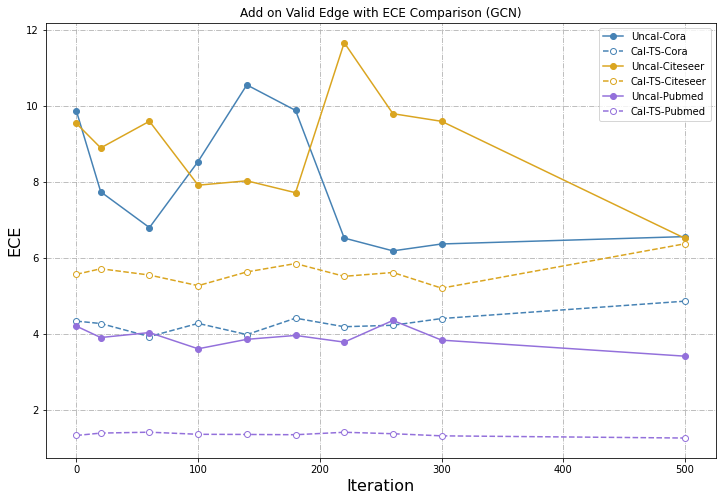

In [79]:
# 5. add-valid GCN (uncal/cal-TS;  Cora/Citeseer/Pumbed)
iteration_list = [0, 20, 60, 100, 140, 180, 220, 260, 300, 500]
ece_uncal_cora = [9.873360830048721, 7.744330799000131, 6.802950789117151, 8.542228779859013, 10.559471427566475, 9.887674337046013, 6.527391158872181, 6.1905224290159016, 6.372007189525498, 6.565862376656797]
ece_cal_cora = [4.34147318204244, 4.278044081810448, 3.9342375782628856, 4.281522902763553, 3.9870297743214502, 4.418947123405006, 4.193454453100761, 4.232463758024904, 4.40919002931979, 4.8666522113813295]
ece_uncal_citeseer = [9.545429754588339, 8.900600164714787, 9.602024851159916, 7.919199961341089, 8.034507371485233, 7.721329066488478, 11.67024802416563, 9.801213174230522, 9.60035262008508, 6.518243066966534]
ece_cal_citeseer = [5.5733071433173285, 5.719767945508162, 5.553911108937529, 5.274545442726877, 5.636043308509721, 5.856587365269661, 5.5204874318506985, 5.620903004374769, 5.209198976970382, 6.377896087037192]
ece_uncal_pubmed = [4.208758390612073, 3.909214265230629, 4.039920214563608, 3.6130113734139337, 3.8618569158845477, 3.964304727398687, 3.788526107867559, 4.359175865021017, 3.8405817209018602, 3.4181039676898055]
ece_cal_pubmed = [1.3311221962794662, 1.393944832185904, 1.4175574088262188, 1.362049282114539, 1.3580603162861533, 1.3506927630967565, 1.4155002724793222, 1.3769582483089633, 1.3213410456147459, 1.2637529599790773]
title5 = 'Add on Valid Edge with ECE Comparison (GCN)'
spth5 = 'figure/modify_edge/add_valid_gcn.png'
draw_add_ratio_ece(iteration_list, ece_uncal_cora, ece_cal_cora, 
                       ece_uncal_citeseer, ece_cal_citeseer, 
                       ece_uncal_pubmed, ece_cal_pubmed, title5, spth5)

Image save to figure/modify_edge/add_valid_gat.png


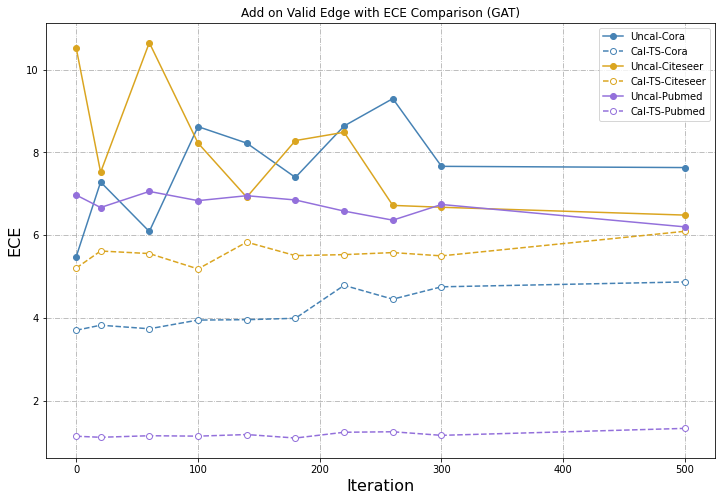

In [80]:
# 6. add-valid GAT (uncal/cal-TS;  Cora/Citeseer/Pumbed)
iteration_list = [0, 20, 60, 100, 140, 180, 220, 260, 300, 500]
ece_uncal_cora = [5.482949006060759, 7.284291968163517, 6.088610159026252, 8.623454647345676, 8.224906658546791, 7.395342809872495, 8.639071602374315, 9.300214766214292, 7.663358613434765, 7.633636053651571]
ece_cal_cora = [3.701251269214683, 3.8234712866445384, 3.7371914833784103, 3.9478908706870346, 3.9567559647063413, 3.9907738980319767, 4.786755817217959, 4.452738124463293, 4.7514657696916, 4.86930777422256]
ece_uncal_citeseer = [10.517280983428162, 7.519559148285124, 10.652156443231636, 8.226436687012512, 6.917616248958641, 8.286189888086584, 8.486795073582067, 6.719429935846064, 6.674151319182581, 6.484793685376644]
ece_cal_citeseer = [5.205591271320978, 5.616759239799447, 5.555035629206233, 5.183573822594352, 5.831649526953697, 5.505175557401445, 5.529468651447031, 5.578780795137087, 5.499284455759658, 6.093420398732027]
ece_uncal_pubmed = [6.968481528262298, 6.66819347275628, 7.057096788452731, 6.834000556005372, 6.953685233990352, 6.850278460317188, 6.581726897921827, 6.3624367117881775, 6.741266056067413, 6.2003424391150475]
ece_cal_pubmed = [1.1400248389691114, 1.114392751413915, 1.1520670907985833, 1.142052985313866, 1.1807185869353511, 1.0963847006981573, 1.235924862946073, 1.2479665404599574, 1.161373013423549, 1.3297220226377249]
title6 = 'Add on Valid Edge with ECE Comparison (GAT)'
spth6 = 'figure/modify_edge/add_valid_gat.png'
draw_add_ratio_ece(iteration_list, ece_uncal_cora, ece_cal_cora, 
                       ece_uncal_citeseer, ece_cal_citeseer, 
                       ece_uncal_pubmed, ece_cal_pubmed, title6, spth6)

Image save to figure/modify_edge/add_all_gcn.png


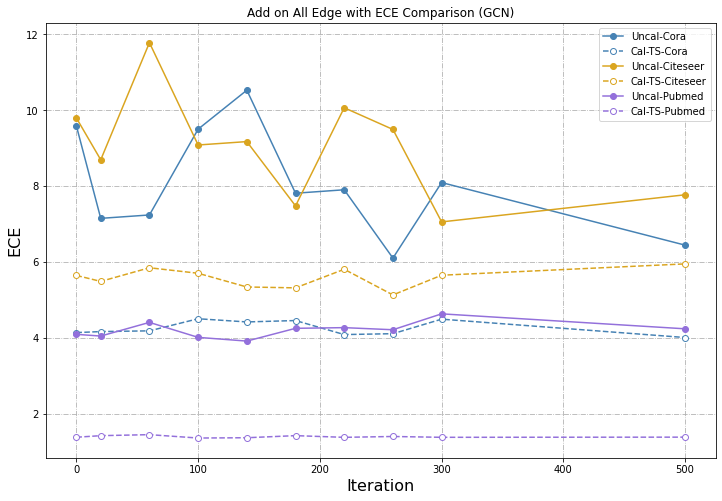

In [81]:
# 7. add-all GCN (uncal/cal-TS;  Cora/Citeseer/Pumbed)
iteration_list = [0, 20, 60, 100, 140, 180, 220, 260, 300, 500]
ece_uncal_cora = [9.586406809588272, 7.150740310963657, 7.240092299050755, 9.501575192229614, 10.528090616895094, 7.813207453323735, 7.903907292832931, 6.103355789350139, 8.094212485270367, 6.444733827892277]
ece_cal_cora = [4.1398391748468075, 4.166825995263126, 4.186131039427386, 4.504832552952899, 4.421048228525453, 4.457593181480965, 4.087880057179265, 4.1113719758060245, 4.49402393359277, 4.010130516770813]
ece_uncal_citeseer = [9.797117134763136, 8.694233848816818, 11.780287408166462, 9.084229667981464, 9.173637028369638, 7.47880974991454, 10.06538961082697, 9.494002411762875, 7.057089627616936, 7.771722475687663]
ece_cal_citeseer = [5.646833197938071, 5.489140521321032, 5.848696589883831, 5.703269876539707, 5.342113951014148, 5.319134787552886, 5.80859093202485, 5.132631667786174, 5.65201954709159, 5.950622964236471]
ece_uncal_pubmed = [4.093643464148045, 4.048869075874487, 4.408952728327778, 4.014289534340302, 3.9161083185010486, 4.252668139007357, 4.270648563073741, 4.215003384484185, 4.634214337501261, 4.239674512710836]
ece_cal_pubmed = [1.3820973690599203, 1.4237396056867309, 1.4503100421279669, 1.3613407551828358, 1.3693306336386335, 1.4242606780802212, 1.3797885479612482, 1.4021430785457292, 1.3803576429684958, 1.3846885154230726]
title7 = 'Add on All Edge with ECE Comparison (GCN)'
spth7 = 'figure/modify_edge/add_all_gcn.png'
draw_add_ratio_ece(iteration_list, ece_uncal_cora, ece_cal_cora, 
                       ece_uncal_citeseer, ece_cal_citeseer, 
                       ece_uncal_pubmed, ece_cal_pubmed, title7, spth7)

Image save to figure/modify_edge/add_all_gat.png


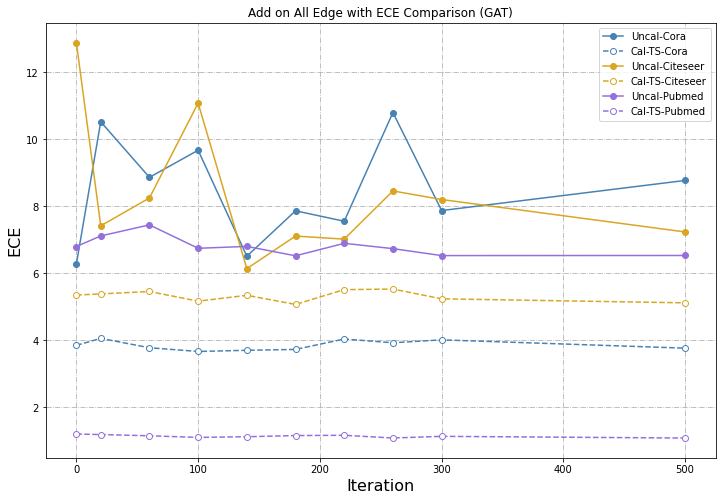

In [83]:
# 8. add-all GAT (uncal/cal-TS;  Cora/Citeseer/Pumbed)
iteration_list = [0, 20, 60, 100, 140, 180, 220, 260, 300, 500]
ece_uncal_cora = [6.283419154998329, 10.522907072057325, 8.865761715504858, 9.67416318340434, 6.5115719102323055, 7.867457997053862, 7.555976261695226, 10.799619741737843, 7.874865084886551, 8.772976675795183]
ece_cal_cora = [3.852640288985438, 4.062096402049065, 3.782352101471689, 3.671102551743388, 3.7058751616213055, 3.7323965173628597, 4.04212846317225, 3.931032224661774, 4.017421147889562, 3.770167204654879]
ece_uncal_citeseer = [12.88285737650262, 7.419441661073102, 8.250294253230095, 11.081292697538931, 6.141945140229331, 7.114124236007531, 7.022382339669599, 8.459910605516699, 8.203897200938728, 7.236275097562207]
ece_cal_citeseer = [5.354073654032416, 5.387781839817762, 5.460924075709449, 5.171279174586138, 5.34604959603813, 5.075283876309792, 5.515655068059763, 5.53260798462563, 5.241921461290784, 5.12149486069878]
ece_uncal_pubmed = [6.801355981992351, 7.117855031457212, 7.44760191688935, 6.749222096469667, 6.805574852559301, 6.525134336617258, 6.897356092101997, 6.738584033317036, 6.531691965129641, 6.5346560958358975]
ece_cal_pubmed = [1.2066860967833135, 1.1930633595006335, 1.1553255039163761, 1.1072825278258986, 1.127454568631947, 1.1624471646630101, 1.1701746636794674, 1.0895175186710226, 1.1386803506563106, 1.0885935147396393]
title8 = 'Add on All Edge with ECE Comparison (GAT)'
spth8 = 'figure/modify_edge/add_all_gat.png'
draw_add_ratio_ece(iteration_list, ece_uncal_cora, ece_cal_cora, 
                       ece_uncal_citeseer, ece_cal_citeseer, 
                       ece_uncal_pubmed, ece_cal_pubmed, title8, spth8)

In [21]:
(val_probs,
test_probs,
val_logits,
test_logits,
val_labels,
test_labels,
logits,
probs,
) = rbs.produce_logits(model, data, device)

In [23]:
val_logits.shape

(985, 3)

In [24]:
test_logits.shape

(14245, 3)

In [27]:
len(torch.nonzero(data.test_mask))

14245

In [28]:
def create_adjacency_matrix(graph):
        index_1 = [edge[0] for edge in graph.edges()] + [
            edge[1] for edge in graph.edges()
        ]
        index_2 = [edge[1] for edge in graph.edges()] + [
            edge[0] for edge in graph.edges()
        ]
        values = [1 for edge in index_1]
        node_count = max(max(index_1) + 1, max(index_2) + 1)
        A = scipy.sparse.coo_matrix(
            (values, (index_1, index_2)),
            shape=(node_count, node_count),
            dtype=np.float32,
        )
        return A

In [71]:
class bin_mask_eqdis(nn.Module):
    def __init__(self, num_bins, sm_vector):
        super(bin_mask_eqdis, self).__init__()
        if not torch.is_tensor(sm_vector):
            self.sm_vector = torch.tensor(sm_vector)
        if torch.cuda.is_available():
            self.sm_vector = self.sm_vector.clone().cuda()
        self.num_bins = num_bins
        self.bins = []
        self.get_equal_bins()

    def get_equal_bins(self):
        for i in range(self.num_bins):
            self.bins.append(torch.tensor(1 / self.num_bins * (i + 1)))

    def get_samples_mask_bins(self):
        mask_list = []
        for i in range(self.num_bins):
            if i == 0:
                mask_list.append(self.sm_vector <= self.bins[i])
            else:
                mask_list.append(
                    (self.bins[i - 1] < self.sm_vector)
                    * (self.sm_vector <= self.bins[i])
                )
        return mask_list

In [35]:
graph = to_networkx(data)
print(graph)

DiGraph with 19717 nodes and 88648 edges


In [43]:
A = create_adjacency_matrix(graph).todense()
print(type(A), A.shape)

<class 'numpy.matrix'> (19717, 19717)


In [44]:
probs.shape

(19717, 3)

In [46]:
AP = A * probs
AP = torch.tensor(AP)

In [52]:
num_neighbors = A.sum(1)
num_neighbors = torch.tensor(num_neighbors)
AP[torch.where(num_neighbors == 0)[0]] = 1
num_neighbors[torch.where(num_neighbors == 0)[0]] = 1

In [56]:
y_pred = torch.tensor(probs).max(1)[1]
AP = AP / num_neighbors.expand(AP.shape[0], AP.shape[1])
conf_AP = []
for i in range(AP.shape[0]):
    conf_AP.append(AP[i, y_pred[i]])
sm_prob = np.array(conf_AP)

In [168]:
sm_prob[0]
AP.shape
y_pred
AP
num_neighbors
torch.where(num_neighbors == 0)[0]
sm_prob.shape
sm_prob.shape
AP.shape
sm_prob
type(probs
    )

numpy.ndarray

In [163]:
conf_AP_tensor = AP[torch.arange(AP.shape[0]), y_pred]

In [173]:
temperature = nn.Parameter(torch.ones(num_bins))

In [174]:
temperature

Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)

In [186]:
val_logits = torch.tensor(val_logits)
T = torch.zeros_like(val_logits)
logits_i = val_logits[bins_mask_list[0]]

/tmp/ipykernel_14050/481811166.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_logits = torch.tensor(val_logits)


In [181]:
logits_i.shape

torch.Size([40, 3])

In [188]:
T

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [182]:
T_i = temperature[0].expand(logits_i.size(0), logits_i.size(1))

In [189]:
T[bins_mask_list[0], :] = T_i.float()

In [190]:
T

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.]], grad_fn=<CopySlices>)

In [193]:
sm_TS_model = bin_mask_eqdis(num_bins, sm_prob)
bins_mask_list_all = sm_TS_model.get_samples_mask_bins()

In [196]:
bins_mask_list_all[0].shape

torch.Size([19717])

In [81]:

# bins_mask_list 里面的元素相当于mask作用
num_bins = 4
sm_val = sm_prob[data.val_mask.detach().cpu().numpy()]
sm_TS_model = bin_mask_eqdis(num_bins, sm_val)
bins_mask_list = sm_TS_model.get_samples_mask_bins()

In [90]:
len(bins_mask_list)
bins_mask_list[0].shape

torch.Size([985])

In [149]:
sm_test = sm_prob[data.test_mask.detach().cpu().numpy()]
sm_TS_model = bin_mask_eqdis(num_bins, sm_test)
bins_mask_list_test = sm_TS_model.get_samples_mask_bins()

In [150]:
len(bins_mask_list_test)
bins_mask_list_test[1].shape

torch.Size([14245])

In [134]:

class TemperatureScaling_bins2(rbs.CalibrationMethod):
    def __init__(self, T_init=1, verbose=False, callback=None):
        super().__init__()
        if T_init <= 0:
            raise ValueError("Temperature not greater than 0.")
        self.T_init = T_init
        self.verbose = verbose

    def fit(self, X, y):

        # Define objective function (NLL / cross entropy)
        def objective(T):
            # Calibrate with given T
            P = scipy.special.softmax(X / T, axis=1)

            # Compute negative log-likelihood
            P_y = P[np.array(np.arange(0, X.shape[0])), y]
            tiny = np.finfo(np.float32).tiny  # to avoid division by 0 warning
            NLL = -np.sum(np.log(P_y + tiny))
            return NLL

        # Derivative of the objective with respect to the temperature T
        def gradient(T):
            # Exponential terms
            E = np.exp(X / T)

            # Gradient
            dT_i = (
                np.sum(
                    E * (X - X[np.array(np.arange(0, X.shape[0])), y].reshape(-1, 1)),
                    axis=1,
                )
            ) / np.sum(E, axis=1)
            grad = -dT_i.sum() / T ** 2
            return grad

        # Optimize
        self.T = scipy.optimize.fmin_bfgs(
            f=objective, x0=self.T_init, fprime=gradient, gtol=1e-06, disp=self.verbose,callback=callback
        )[0]

        # Check for T > 0
        if self.T <= 0:
            raise ValueError("Temperature not greater than 0.")

        return self, self.T

    def predict_proba(self, X):

        # Check is fitted
        check_is_fitted(self, "T")
        # Transform with scaled softmax
        return scipy.special.softmax(X / self.T, axis=1)

In [139]:
T_list = []

for i in range(num_bins):
    T_history = []  
    def callback(T):
        T_history.append(T.copy())
    TS_model = TemperatureScaling_bins2(verbose=True, callback=callback)
    T = TS_model.fit(val_logits[bins_mask_list[i].cpu().numpy()], val_labels[bins_mask_list[i].cpu().numpy()])
    print(T_history)
    T_list.append(torch.tensor(T[1]))

Optimization terminated successfully.
         Current function value: 36.000746
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
[array([1.06870875]), array([1.05881985]), array([1.05740748]), array([1.05744209])]
Optimization terminated successfully.
         Current function value: 33.988647
         Iterations: 5
         Function evaluations: 10
         Gradient evaluations: 10
[array([0.76657165]), array([0.70483751]), array([0.70017754]), array([0.70101688]), array([0.70100704])]
Optimization terminated successfully.
         Current function value: 82.647574
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
[array([0.8828572]), array([0.91065959]), array([0.90589452]), array([0.90563966]), array([0.9056425])]
Optimization terminated successfully.
         Current function value: 195.123348
         Iterations: 7
         Function evaluations: 12
         Gradient evaluations: 10
[array([0.66391077])

/tmp/ipykernel_14050/3641172884.py:25: RuntimeWarning: overflow encountered in exp
  E = np.exp(X / T)
/tmp/ipykernel_14050/3641172884.py:28: RuntimeWarning: invalid value encountered in divide
  dT_i = (


In [152]:
def get_rescaled_logits(T_list, logits, bins_mask_list):
    T = torch.zeros_like(logits)
    for i in range(num_bins):
        # The i-th bin logits
        logits_i = logits[bins_mask_list[i]]
        # Expand temperature to match the size of logits
        T_i = T_list[i].expand(logits_i.size(0), logits_i.size(1))
        T[bins_mask_list[i], :] = T_i.float()
    logits0 = logits / T
    return logits0

In [153]:
cal_probs_test = torch.softmax(
        get_rescaled_logits(T_list, torch.tensor(test_logits), bins_mask_list_test), 1
    )

In [156]:
T_list
cal_probs_test

tensor([[6.2440e-04, 9.4628e-01, 5.3099e-02],
        [7.5580e-01, 1.5702e-01, 8.7187e-02],
        [1.0235e-02, 1.7056e-02, 9.7271e-01],
        ...,
        [7.2498e-01, 1.6179e-01, 1.1323e-01],
        [2.5265e-03, 1.5301e-02, 9.8217e-01],
        [1.4934e-03, 2.7585e-03, 9.9575e-01]])

In [157]:

nn.Parameter(torch.ones(4))

Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)

array([2.75791811e+10, 1.62689188e+11, 2.33824870e+09, 1.17006309e+04,
       1.97553616e+08, 7.31307150e+06, 3.79876352e+09, 1.31498022e+09,
       6.19727500e+05, 2.88127821e+09, 8.20537600e+07, 9.94469504e+08,
       2.57684537e+12, 3.40832027e+12, 1.31841374e+17, 2.35125750e+05,
       8.20359062e+05, 2.41194039e+14, 1.58583783e+11, 1.41908234e+31,
       1.52748319e+10, 1.07829491e+09, 1.91817408e+09, 1.27407783e+04,
       4.07524188e+05, 4.13743579e+11, 8.34305901e+16, 4.72809453e+04,
       1.56866516e+03, 1.11653736e+13, 2.72222832e+04, 2.66950323e+09,
       3.04140520e+07, 1.00215613e+12, 8.84825216e+08, 6.10762812e+05,
       1.61855400e+06, 3.81332980e+11, 1.17198847e+13, 4.39591010e+11,
       1.63988105e+04, 5.56243750e+05, 1.56869488e+06, 3.28401504e+13,
       5.28457056e+08, 2.02263751e+14, 1.96455757e+09, 2.41204539e+17,
       1.78673818e+09, 6.15815373e+10, 2.00048336e+13, 1.38497200e+08,
       5.91072277e+12, 4.29987700e+06, 2.39453440e+09, 3.68146280e+07,
      

In [101]:
print(ts_model)
print(type(val_logits), val_logits.shape)

TemperatureScaling_bins()
<class 'numpy.ndarray'> (985, 3)


In [3]:
split = 1
fold = 1
init = 1

In [4]:
# Load data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = load_data(args.dataset, args.split_type, split, fold)
data = dataset.data.to(device)

In [5]:
print(args)
set_global_seeds(10)

Namespace(cal_dropout_rate=0.5, cal_wdecay=None, calibration='GATS', config=False, dataset='Pubmed', dropout_rate=0.5, ece_bins=15, ece_norm=1.0, ece_scheme='equal_width', folds=3, gats_args=Namespace(bias=1, heads=2), help=None, model='GCN', save_prediction=False, seed=10, split_type='5_3f_85', verbose=False, wdecay=0.0005)


In [6]:
# Load model
from src.model.model import create_model
from pathlib import Path

model = create_model(dataset, args).to(device)
model_name = name_model(fold, args)
dir = Path(os.path.join('model', args.dataset, args.split_type, 'split'+str(split), 'init'+ str(init)))
file_name = dir / (model_name + '.pt')
model.load_state_dict(torch.load(file_name))
torch.cuda.empty_cache()

In [7]:
model

GCN(
  (layer_list): ModuleDict(
    (conv1): GCNConv(500, 64)
    (conv2): GCNConv(64, 3)
  )
)

In [8]:
data

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])

In [9]:
data.train_mask

tensor([ True, False, False,  ..., False, False, False], device='cuda:0')

In [9]:
print(torch.count_nonzero(data.train_mask))
print(torch.count_nonzero(data.val_mask))
print(torch.count_nonzero(data.test_mask))

tensor(1971, device='cuda:0')
tensor(985, device='cuda:0')
tensor(14245, device='cuda:0')


In [34]:
train_dataset = default_dataset
train_val_dataset = default_dataset
val_dataset = default_dataset

torch_geometric.data.data.Data

tensor([[   30],
        [   31],
        [   36],
        [   53],
        [   74],
        [  160],
        [  223],
        [  233],
        [  261],
        [  262],
        [  358],
        [  378],
        [  385],
        [  431],
        [  453],
        [  470],
        [  489],
        [  494],
        [  509],
        [  512],
        [  537],
        [  542],
        [  555],
        [  557],
        [  561],
        [  588],
        [  616],
        [  622],
        [  676],
        [  692],
        [  699],
        [  730],
        [  777],
        [  799],
        [  815],
        [  862],
        [  866],
        [  876],
        [  927],
        [  932],
        [  943],
        [  958],
        [  966],
        [  999],
        [ 1039],
        [ 1054],
        [ 1059],
        [ 1073],
        [ 1076],
        [ 1142],
        [ 1168],
        [ 1171],
        [ 1185],
        [ 1192],
        [ 1209],
        [ 1255],
        [ 1269],
        [ 1277],
        [ 1333